<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Anikas_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?


A decision tree is very similar to a flow chart. It helps make desicions with a series of yes or no questions. It starts out with one big problem/ question and splits into smaller branches based on the answers. This keeps going until you reach a final desicison.




**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a descision tree is like the number of questions you have to answer to reach a final desicion (aka the number of splits from the root to the deepest leaf). If you ask very specific questions (making the tree too eep), you might end up memorsing exact answers but struggle the new situations (overfitting). If you ask too few questions (making the tree too shallow), you might not get enough detail to make a good guess (underfittting). The goal is finding the right balance so the tree can make good decisions for any case.







**Task4:**

How are BART models similar and different from a decision tree?

BART models and decision trees are like different ways of solving problems using trees. A decision tree is like a big, detailed flowchart that leads to one final answer. Barth is like a team of many small decison trees working together to make a better guess. The Biggest difference os that BART uses a probability-based approach (Bayesian methods) to measure uncertainty, whicle a regualr descion tree just picks one answer without considering how unure it might be.

**Task5**:

Why would we use a BART model instead of a decision tree?

Using a BART model instead of a decision tree is like asking a group of experst instead of relying on just one persons opinion. A single decision tree can easily overfit, meaning it might memorize the data too well and stuggle with new situations. BART, since it combinees many small trees, avoids htis problme and gives more reliable answers. It also does a better job of understanding complex patterns and even tells you how confident it is in its predictions, which a single decision tree can't do.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
!pip install pymc-bart
!pip install preliz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [3]:
from sklearn import tree

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [16]:
X = penguins[['flipper_length',
              'bill_depth',
              'bill_length',
]]
Y = penguins["body_mass"].to_numpy()

In [17]:
with pm.Model() as model_penguinR:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_penguinR = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

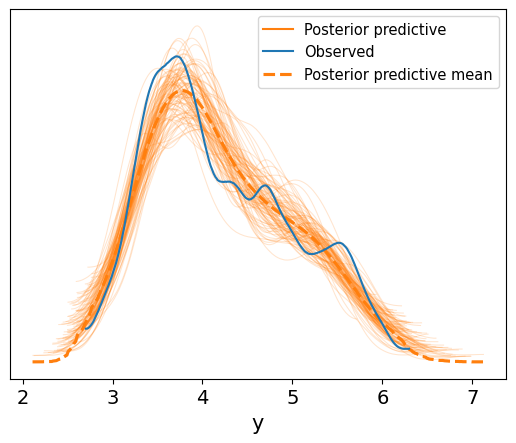

In [18]:
#posterior predictive dist
pm.sample_posterior_predictive(idata_penguinR,model_penguinR, extend_inferencedata=True)
az.plot_ppc(idata_penguinR, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [29]:
X = penguins["flipper_length"].to_numpy().reshape(-1, 1)
Y = penguins["body_mass"].to_numpy()

In [30]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_penguin = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

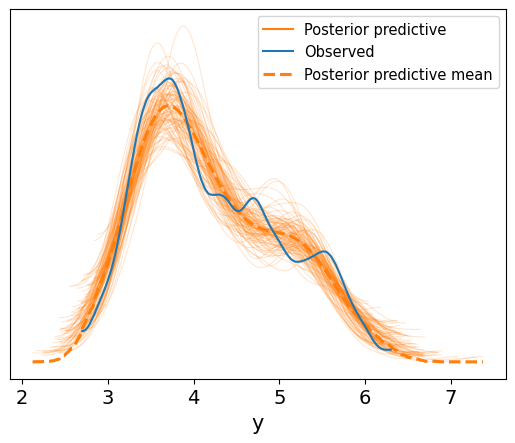

In [31]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_penguin,model_penguin, extend_inferencedata=True)
az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [32]:

posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguin, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


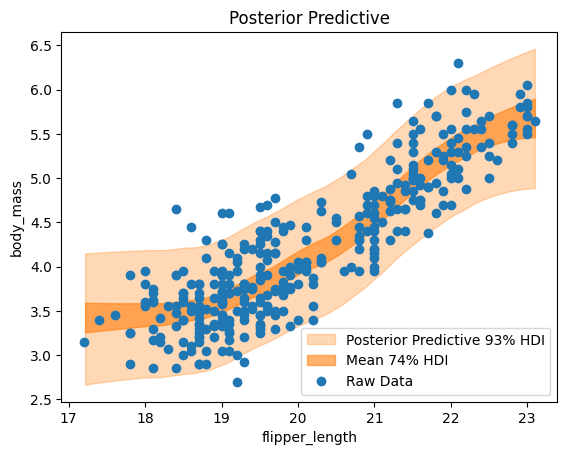

In [34]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

Overall the model captured the relationship between flipper_length & body_mass. The plot confirms that penguins with longer flippers tend to have greater body mass. This positive relationship is shown by the upward slope of the shaded areas. The plot also shows the model’s confidence in its predictions. The model is more confident about penguins with average flipper lengths. For penguins with very short or very long flippers, the model is less confident, as indicated by the wider shaded areas at the edges of the plot.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

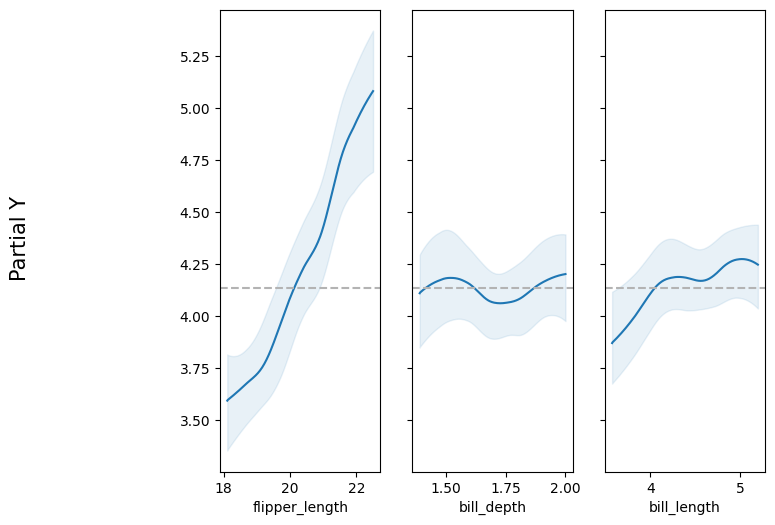

In [19]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

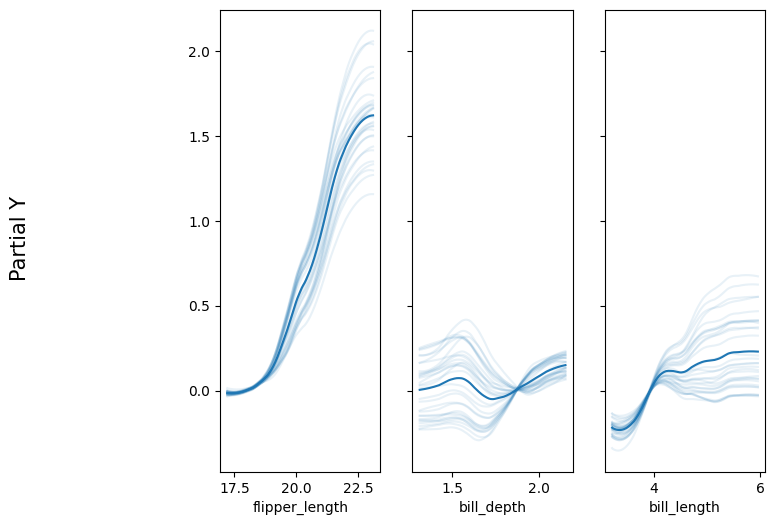

In [20]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [21]:
vi_penguin = pmb.compute_variable_importance(idata_penguinR, μ_, X)

<Axes: ylabel='R²'>

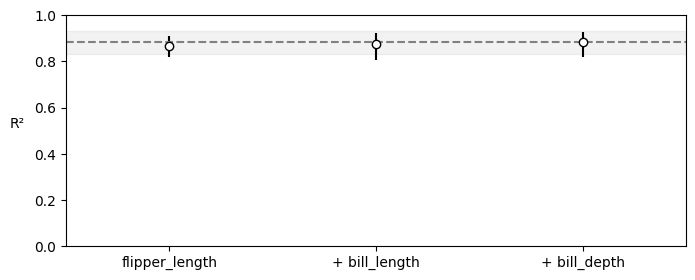

In [22]:
pmb.plot_variable_importance(vi_penguin)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Flipper length is the most important predictor of penguin body mass, because the strong upward trend in both the partial dependence (PDP) and individual conditional expectation(ICE) plots. Bill depth has a more weird, U-shaped relationship, suggesting potential interactions with other variables rather than a simple linear effect. Bill length shows little influence on body mass , with a relatively flat trend showing a weak or negligiible impact. The wide shaded areas in the PDP and ICE plots for bill depth and bill length could mean that there is greater uncertainty, so flipper length is the most reliable predictor.